In [1]:
#importing libraries necessary to the purpose
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import ttest_ind
from matplotlib import pyplot
import sys
from IPython import display
import geopandas as gp

In [2]:
path = sys.path[0]

In [106]:
#Reading the csv file containg demografics data of italian province
df= pd.read_csv(path+'/DCIS_RICPOPRES2011_20072022225124863.csv')
df

,ITTER107,Territorio,TIPO_DATO15,Tipo dato,ETA1,Classe di età,SEXISTAT1,Sesso,CITTADINANZA,Cittadinanza,TIME,Seleziona periodo,Value,Flag Codes,Flags
0,IT,Italia,JAN,popolazione al 1º gennaio,Y0,0 anni,1,maschi,ITL,italiano-a,2002,2002,254875,NaN,NaN
1,IT,Italia,JAN,popolazione al 1º gennaio,Y0,0 anni,1,maschi,ITL,italiano-a,2003,2003,258032,NaN,NaN
2,IT,Italia,JAN,popolazione al 1º gennaio,Y0,0 anni,1,maschi,ITL,italiano-a,2004,2004,261121,NaN,NaN
3,IT,Italia,JAN,popolazione al 1º gennaio,Y0,0 anni,1,maschi,ITL,italiano-a,2005,2005,262384,NaN,NaN
4,IT,Italia,JAN,popolazione al 1º gennaio,Y0,0 anni,1,maschi,ITL,italiano-a,2006,2006,257839,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,ITE41,Viterbo,JAN,popolazione al 1º gennaio,Y37,37 anni,9,totale,FRG,straniero-a,2007,2007,325,NaN,NaN
999996,ITE41,Viterbo,JAN,popolazione al 1º gennaio,Y37,37 anni,9,totale,FRG,straniero-a,2008,2008,430,NaN,NaN
999997,ITE41,Viterbo,JAN,popolazione al 1º gennaio,Y37,37 anni,9,totale,FRG,straniero-a,2009,2009,500,NaN,NaN
999998,ITE41,Viterbo,JAN,popolazione al 1º gennaio,Y37,37 anni,9,totale,FRG,straniero-a,2010,2010,579,NaN,NaN


In [4]:
#creting a geoframe (gf) using the Veneto regions shapefile
gf= gp.read_file(path+'/Veneto_Shapes/veneto.shp')

In [5]:
gf

,COD_REG,COD_PRO,NOME_PRO,SHAPE_Leng,SHAPE_Area,geometry
0,5,25,BELLUNO,423198.443047,3.672244e+09,"POLYGON ((768209.001 5175597.001, 768220.251 5..."
1,5,23,VERONA,338110.183921,3.096210e+09,"POLYGON ((646545.575 5070730.102, 646486.486 5..."
2,5,24,VICENZA,320767.264586,2.721103e+09,"POLYGON ((696629.063 5098859.001, 697068.873 5..."
3,5,29,ROVIGO,326755.143452,1.819024e+09,"POLYGON ((761747.751 5004709.001, 761672.251 5..."
4,5,26,TREVISO,297477.550271,2.479183e+09,"POLYGON ((758399.001 5108310.001, 758460.001 5..."
5,5,27,VENEZIA,440287.155837,2.473103e+09,"POLYGON ((795239.823 5081909.540, 795380.292 5..."
6,5,28,PADOVA,327407.294066,2.144633e+09,"POLYGON ((721251.001 5062355.501, 721341.251 5..."


<AxesSubplot:>

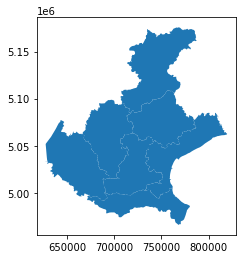

In [6]:
#basic plot of 7 regions of Veneto
gf.plot()

In [7]:
#filtering the dataframe containing all the provinces of Italy with only provinces of Veneto (ve dataframe)
venetoprovinces= ['Venezia','Verona','Padova','Treviso','Vicenza','Rovigo','Belluno']
ve=df[df.Territorio.isin(venetoprovinces)]

In [8]:
#proceeding the analysis without taking into account gender
ve=ve.loc[ve['Sesso']=='totale']
#excluding summarising 'TOTAL' rows on the df
ve=ve.loc[ve['ETA1']!='TOTAL']
ve.head(3)

,ITTER107,Territorio,TIPO_DATO15,Tipo dato,ETA1,Classe di età,SEXISTAT1,Sesso,CITTADINANZA,Cittadinanza,TIME,Seleziona periodo,Value,Flag Codes,Flags
2034,ITD31,Verona,JAN,popolazione al 1º gennaio,Y0,0 anni,9,totale,ITL,italiano-a,2002,2002,7154,NaN,NaN
2035,ITD31,Verona,JAN,popolazione al 1º gennaio,Y0,0 anni,9,totale,ITL,italiano-a,2003,2003,7214,NaN,NaN
2036,ITD31,Verona,JAN,popolazione al 1º gennaio,Y0,0 anni,9,totale,ITL,italiano-a,2004,2004,7221,NaN,NaN


In [9]:
#ve=ve.loc[ve['Cittadinanza']=='italiano-a']

In [10]:
#funtion remove that remove 'Y_GE100' of the year column and substitute with int 100 value
def remove(x):
    if x!='Y_GE100':
        x=x[1:]
    else:
        x=100
    return x

ve['eta']=ve.ETA1.apply(lambda x: remove(x))
ve=ve.astype({'eta': 'int64'})

In [11]:
#function that returns a dictionary (pop4prov): provinces name are keys, a list of province popolation 
# throughout years are values of the dictionary
def incr_pop():
    pop4prov={}
    for provincia in venetoprovinces:
        prov=df[df.Territorio.isin([provincia])]
        l=[]
        years=sorted(prov.TIME.unique())
        for year in years:
            l.append(prov.groupby('TIME').get_group(year).Value.sum())
        pop4prov[provincia]=l
    return pop4prov
pop4prov=incr_pop()

# Aging index (Indice Vecchiaia = IV)
* aging index is compute as the sum of the population over 66 divided by the population younger than 15 

In [12]:
#function that returns a dictionary (iv4prov): provinces name are keys, a list of province aging index 
# throughout years are values of the dictionary
def incr_iv():
    iv4prov={}
    for provincia in venetoprovinces:
        prov=ve[ve.Territorio.isin([provincia])]
        l=[]
        years=sorted(prov.TIME.unique())
        for el in years:
            year=prov.groupby('TIME').get_group(el)
            mag65=year.loc[year.eta>=65].Value.sum()
            min14=year.loc[year.eta<=14].Value.sum()
            l.append(mag65/min14)
        iv4prov[provincia]=l
    return iv4prov
iv4prov=incr_iv()

In [13]:
#I didn't know how to do the avg IV of veneto in a easier way
s=0
n=0
for prov,val in iv4prov.items():
    for el in val:
        n+=1
        s+=el
print(s/n)


1.5800945922705472


In [14]:
vi=ve[ve.Territorio.isin(['Vicenza'])] #dataframe filtered for only Vicenza province

In [15]:
years=sorted(vi.TIME.unique())

## Great one

In [61]:
gf['coordinates']=gf.centroid

In [33]:
gf.columns

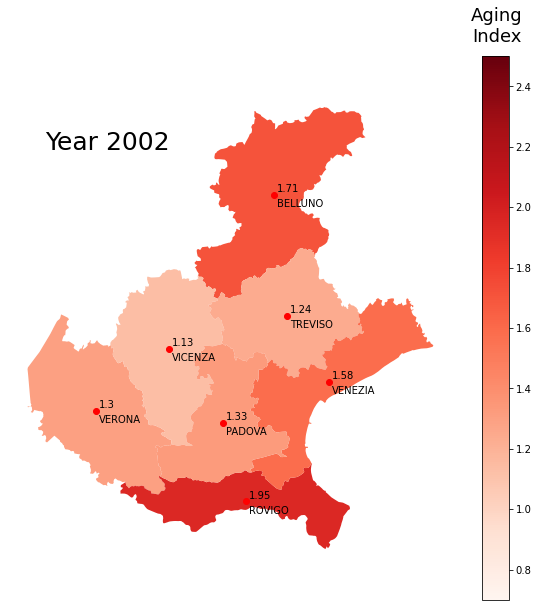

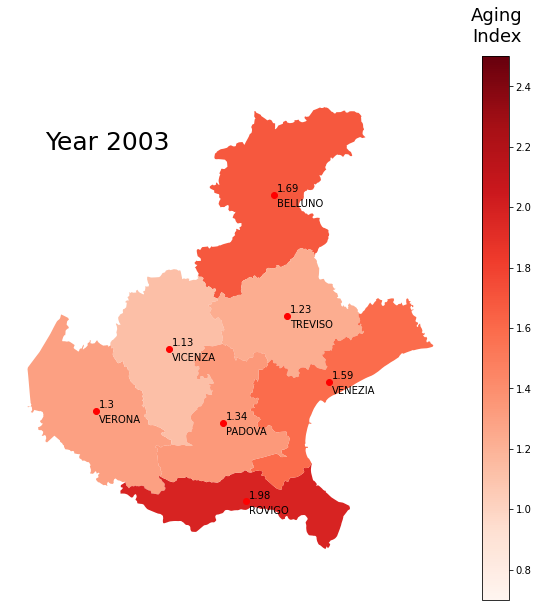

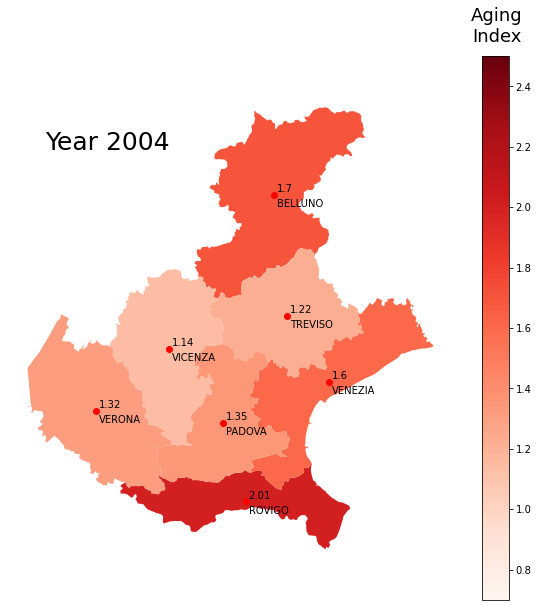

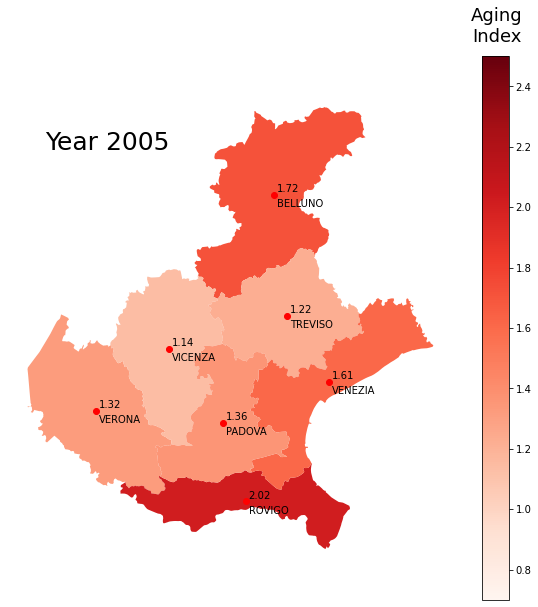

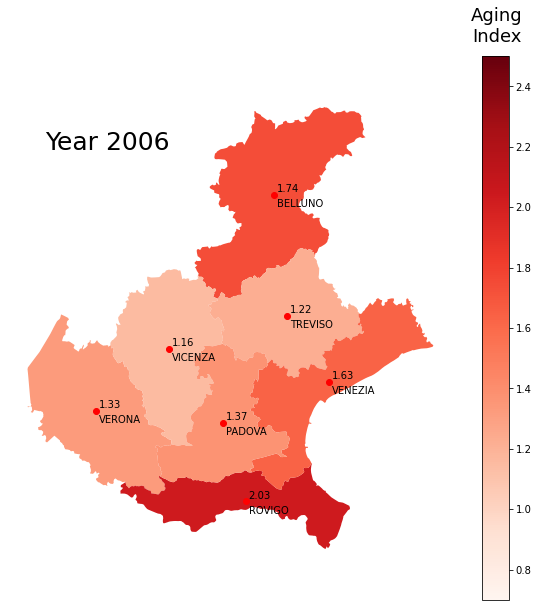

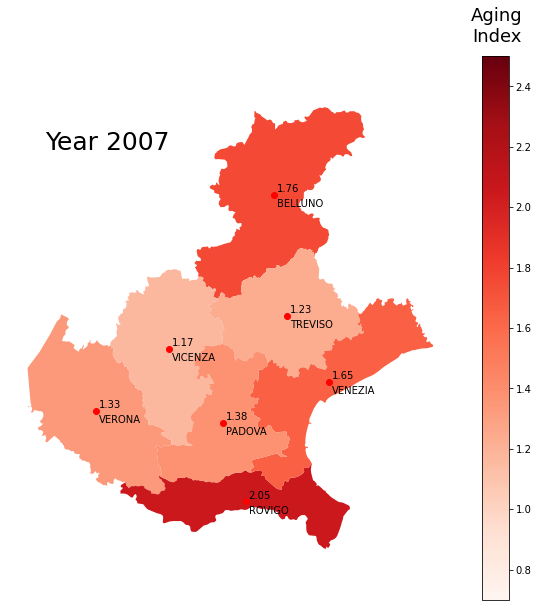

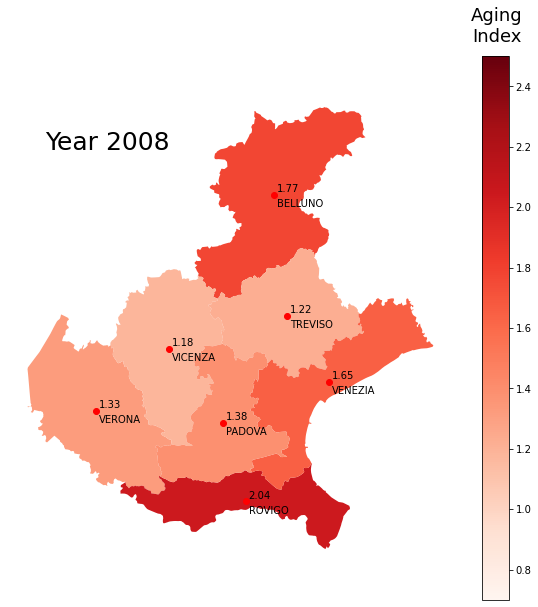

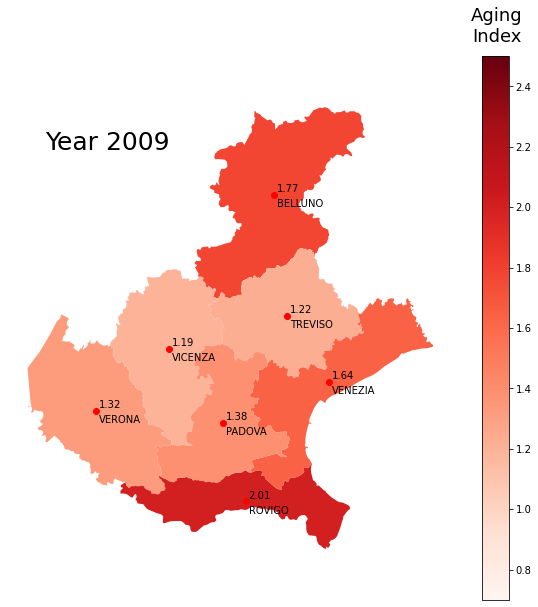

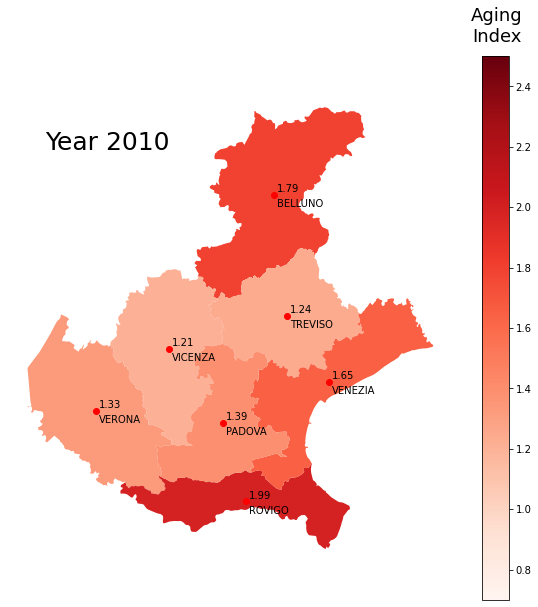

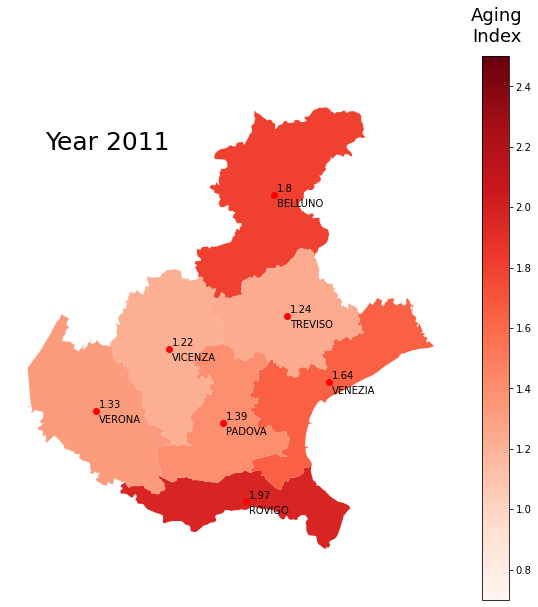

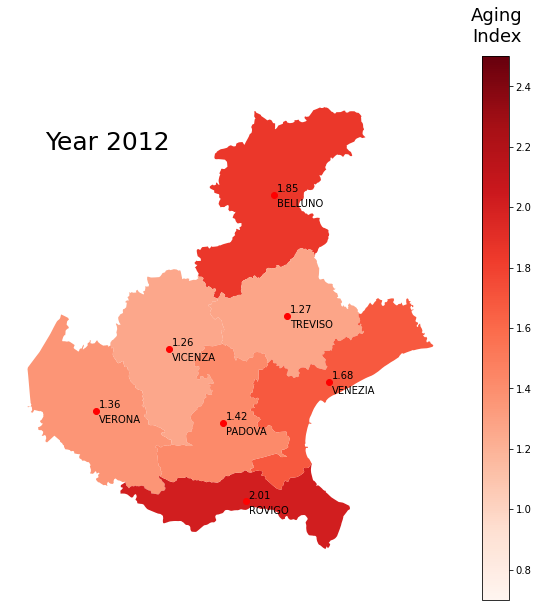

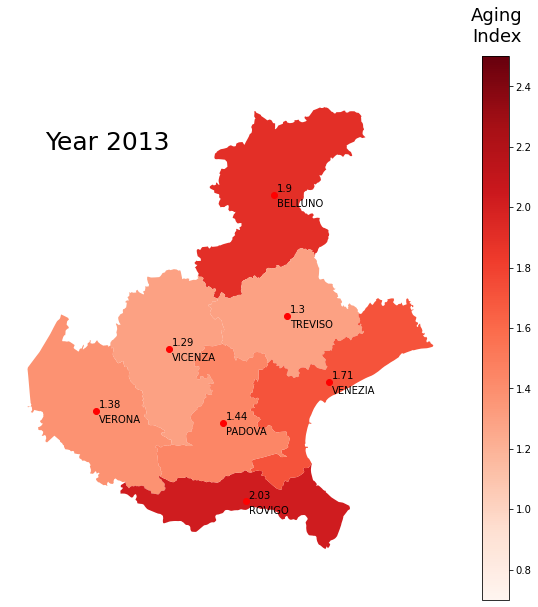

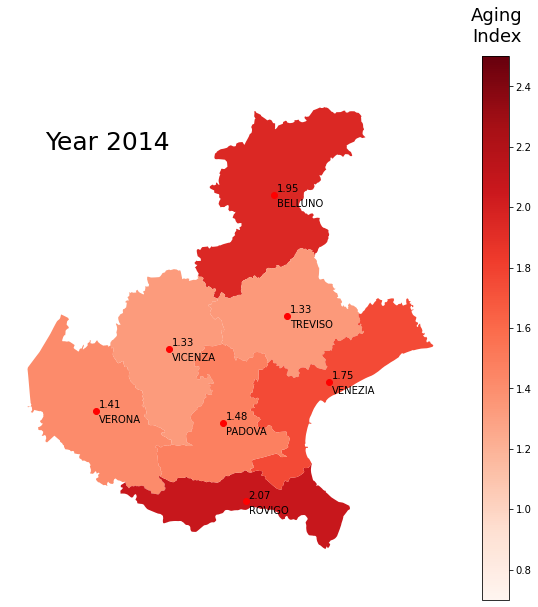

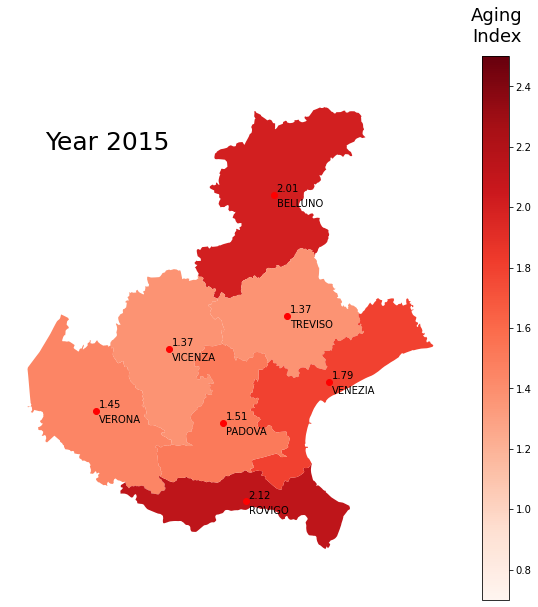

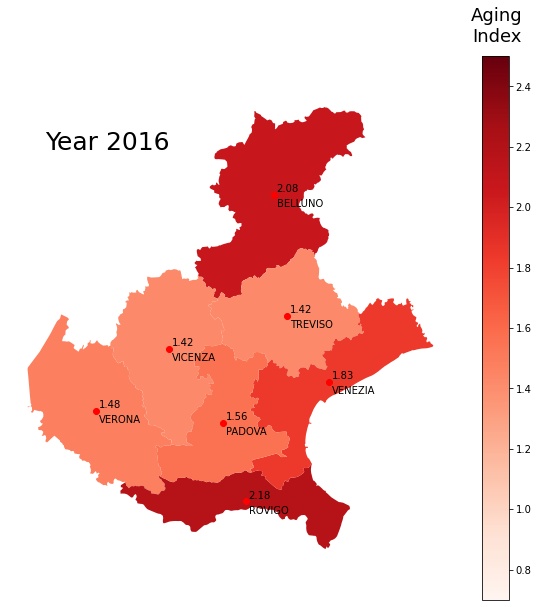

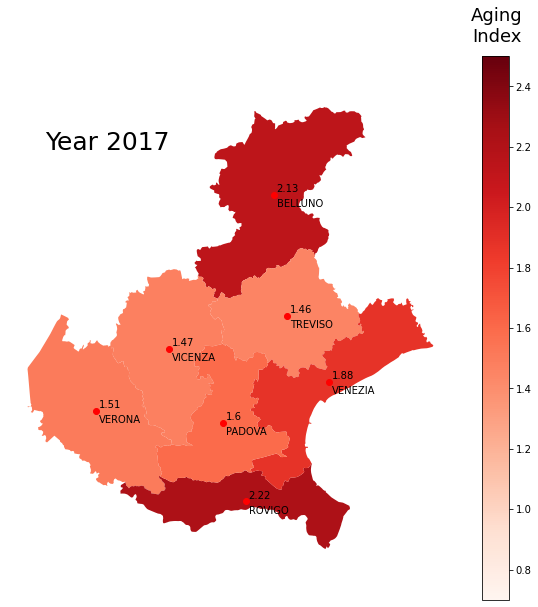

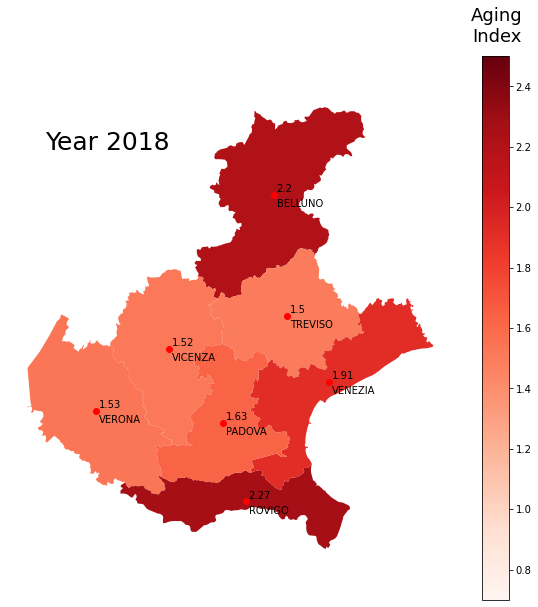

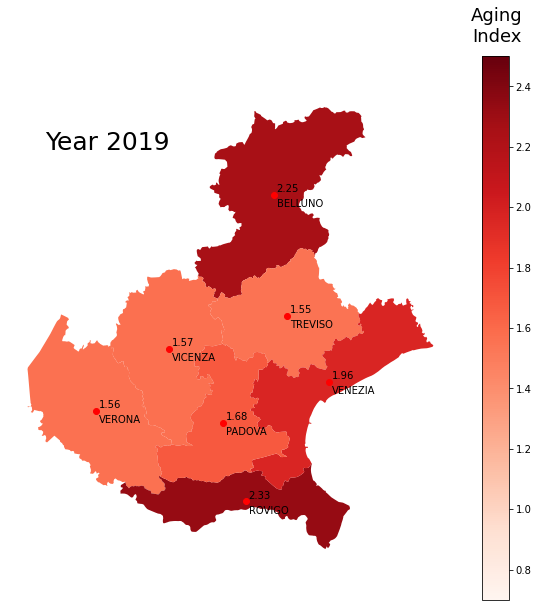

In [104]:
for year in range(18):
    for prov, iv in iv4prov.items():
        gf.loc[gf.NOME_PRO==prov.upper(),'iv_inc']=iv[year]
    gf=gf.astype({'iv_inc': 'float'})
    ax=gf.plot(column='iv_inc', legend=True,cmap='Reds',vmin=0.7,vmax=2.5,figsize=(10,10))
    gf.coordinates.plot(ax=ax, color='red')
    plt.axis('off')
    for x, y, label,label2 in zip(gf.coordinates.x, gf.coordinates.y,round(gf.iv_inc,2),gf.NOME_PRO):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
        ax.annotate(label2, xy=(x, y), xytext=(3, -12), textcoords="offset points")
    plt.figtext(0.35, 0.75,'Year '+ str(years[year]), horizontalalignment='right', fontsize=25)
    plt.figtext(0.84, 0.90, 'Aging\nIndex', horizontalalignment='right', fontsize=18)
    title=str(year)+'.png'
    #plt.savefig(title)

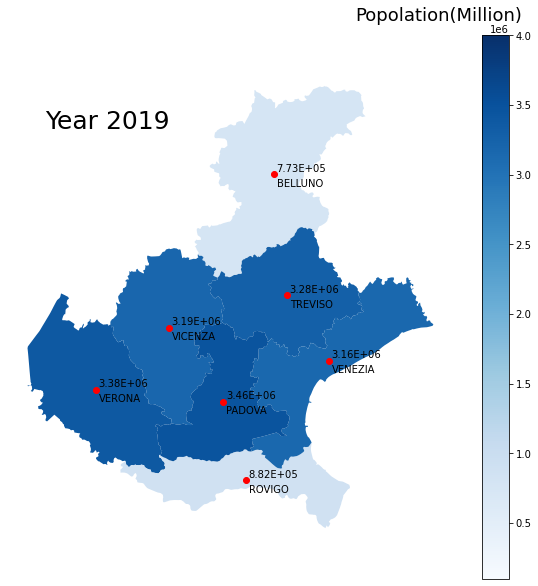

In [105]:
from decimal import Decimal
for year in range(17,18):
    for prov, pop in pop4prov.items():
        gf.loc[gf.NOME_PRO==prov.upper(),'pop_inc']=pop[year]
    gf=gf.astype({'pop_inc': 'int64'})
    ax=gf.plot(column='pop_inc', legend=True,cmap='Blues',vmin=100000,vmax=4000000,figsize=(10,10))
    gf.coordinates.plot(ax=ax, color='red')
    plt.axis('off')
    gf['decimal']=gf.pop_inc.apply(lambda x: '%.2E' % Decimal(x))
    for x, y, label,label2 in zip(gf.coordinates.x, gf.coordinates.y,gf.decimal,gf.NOME_PRO):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
        ax.annotate(label2, xy=(x, y), xytext=(3, -12), textcoords="offset points")
    plt.figtext(0.35, 0.75,'Year '+ str(years[year]), horizontalalignment='right', fontsize=25)
    plt.figtext(0.84, 0.90, 'Popolation(Million)', horizontalalignment='right', fontsize=18)
    title=str(year)+'.png'
    plt.savefig(title)